# 01 Skin Lesion Segmentation using Mask R-CNN

## 1. Environment and Dependencies Setup

### 1.1 Install pytorch with GPU support

In [20]:
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

### 1.2 Imports and Dependencies

In [20]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [21]:
from src.mask.engine import train_one_epoch
import src.mask.utils as utils
import src.mask.transforms as T
from src.mask.coco_annotations import create_coco_annotations
from src.mask.mask_evaluation import evaluate

In [22]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["savefig.dpi"] = 300
pd.set_option("display.max_columns", None)

HAM10000_DIR = "../data/HAM10000" # Update this path as needed

### 1.3 System Configuration and Constants

In [23]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090


In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # 1 class (lesion) + background

## 2. Data Preparation

### 2.1 Custom dataset classes (HAM10000)

In [25]:
class HAM10000Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        # Upload names of all images and masks and sort them
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        
        # Open mask (convert to numpy array)
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        # Create binary masks for each object
        masks = mask == obj_ids[:, None, None]

        # Calculate Bounding Boxes
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert everything into torch tensors
        if num_objs == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = torch.ones((num_objs,), dtype=torch.int64) # Label 1 = skin lesion
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Apply any transformations
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### 2.2 Defining Transforms

In [26]:
import torchvision.transforms.functional as F

class ToTensor(torch.nn.Module):
    def forward(self, image, target):
        image = F.to_tensor(image)
        return image, target
    
def get_transform():
    transforms = []
    transforms.append(ToTensor()) 
    return T.Compose(transforms)

### 2.3 DataLoaders

In [27]:
#funtion to filter images without masks
def filter_dataset(ds):
    valid_indices = []
    for i in range(len(ds)):
        _, target = ds[i]
        if target["masks"].shape[0] > 0:   # tiene máscara
            valid_indices.append(i)
    return torch.utils.data.Subset(ds, valid_indices)

In [28]:
data = HAM10000Dataset(HAM10000_DIR, get_transform())

In [29]:
dataset = filter_dataset(data)

In [30]:
from torch.utils.data import random_split

total_len = len(dataset)

train_len = int(0.7 * total_len)
temp_len  = total_len - train_len   # 30%

val_len = int(0.3333 * temp_len)    # 10%
test_len = temp_len - val_len       # 20%

print(f"Train: {train_len}, Val: {val_len}, Test: {test_len}")

train_ds, temp_ds = random_split(dataset, [train_len, temp_len],
                                 generator=torch.Generator().manual_seed(42))

val_ds, test_ds = random_split(temp_ds, [val_len, test_len],
                               generator=torch.Generator().manual_seed(42))


Train: 7009, Val: 1001, Test: 2003


In [31]:
data_loader_train = torch.utils.data.DataLoader(
    train_ds, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_val = torch.utils.data.DataLoader(
    val_ds, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    test_ds, batch_size=8, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn
)


### 2.4 Data Exploration (EDA)

[9952, 3005, 8589]


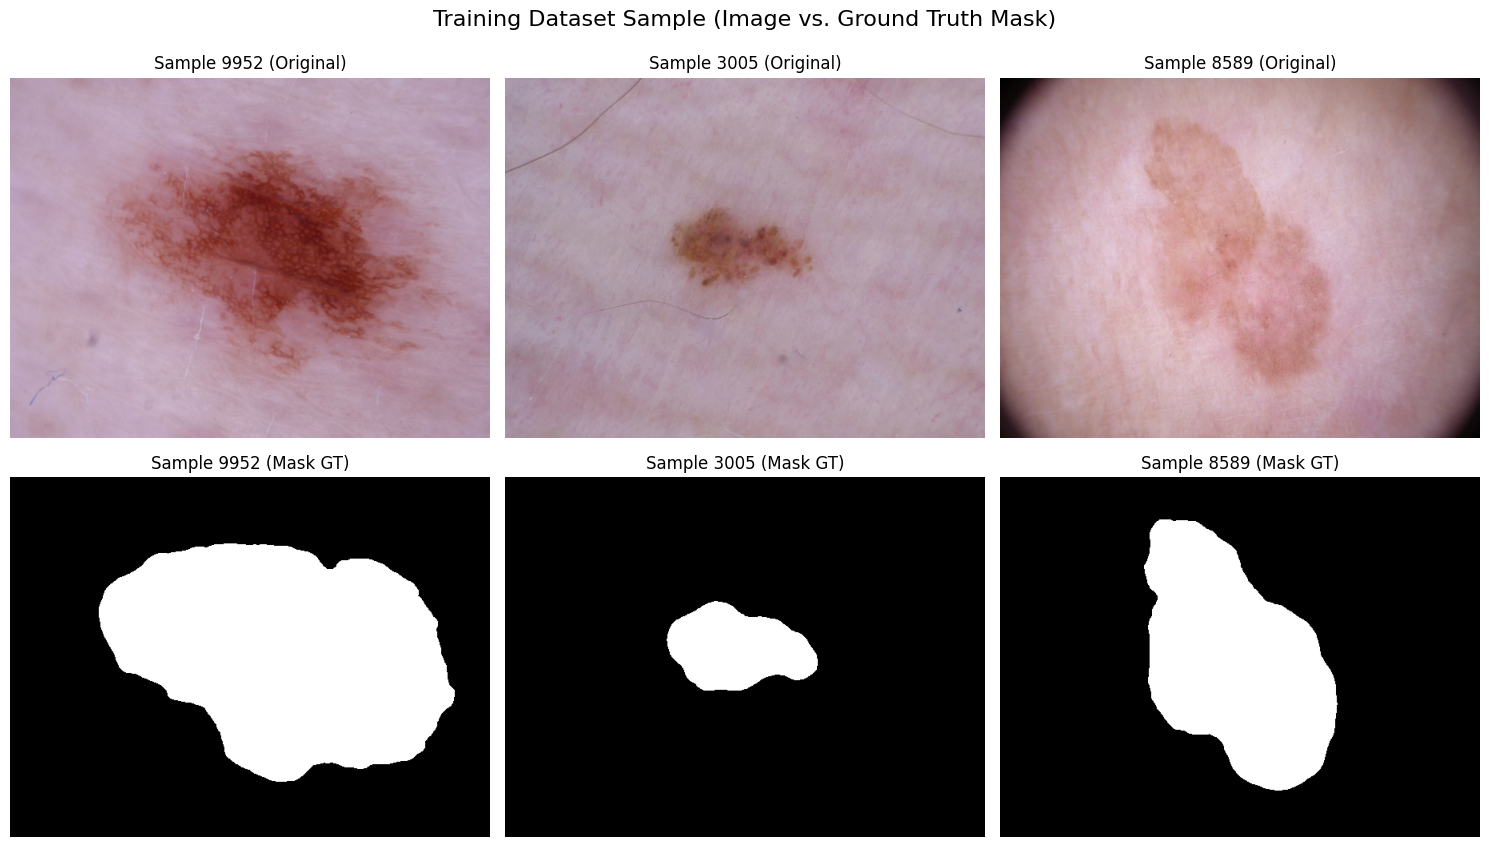

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle('Training Dataset Sample (Image vs. Ground Truth Mask)', fontsize=16, y=0.92)

indices_to_show = random.sample(range(len(dataset)), 3)
print(indices_to_show)

for i, idx in enumerate(indices_to_show):
    img_tensor, target = dataset[idx]
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

    mask_tensor = target['masks'][0] 
    mask_np = mask_tensor.cpu().numpy()
    
    # Row 1: Original Image
    ax_img = axes[0, i]
    ax_img.imshow(img_np)
    ax_img.set_title(f"Sample {idx} (Original)")
    ax_img.axis('off')
    
    # Row 2: Binary Mask
    ax_mask = axes[1, i]
    ax_mask.imshow(mask_np, cmap='gray') 
    ax_mask.set_title(f"Sample {idx} (Mask GT)")
    ax_mask.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

## 3. Model Definition and Training Components

### 3.1 Model Definition

In [33]:
def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) # Load pre-trained model on COCO

    # Replace the box predictor (FastRCNN)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor (MaskRCNN)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

### 3.2 Optimizer and Scheduler Setup

In [34]:
# Instantiate the model
model = get_model(num_classes)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [35]:
class EarlyStopping:
    def __init__(self, patience, verbose, delta, path):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [36]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.005)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Scheduler to decrease LR by 10x every 3 epochs
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Cambia step_size=3 por 15
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

early_stopping = EarlyStopping(patience=8, verbose=True, delta=0,path='../models/best_model.pth')
num_epochs = 50

## 4. Training loop excecution

### 4.1 Loop excecution

In [37]:
train_loss_history = []
val_dice_history = []
val_iou_history = []
val_precision_history = []
val_recall_history = []
val_specificity_history = []
val_accuracy_history = []
lr_history = []

In [38]:
for epoch in range(num_epochs):

    # --- TRAIN ---
    avg_loss = train_one_epoch(
        model, optimizer, data_loader_train, device, epoch, print_freq=100
    )
    train_loss_history.append(avg_loss.meters['loss'].global_avg)

    lr_history.append(optimizer.param_groups[0]['lr'])

    # --- VALIDATION ---
    metrics = evaluate(model, data_loader_val, device)

    val_dice_history.append(metrics['mean_dice'])
    val_iou_history.append(metrics['mean_iou'])
    val_precision_history.append(metrics['mean_precision'])
    val_recall_history.append(metrics['mean_recall'])
    val_specificity_history.append(metrics['mean_specificity'])
    val_accuracy_history.append(metrics['mean_accuracy'])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train Loss: {train_loss_history[-1]:.4f}")
    print(f" Val Dice: {metrics['mean_dice']:.4f}, Val IoU: {metrics['mean_iou']:.4f}")

    lr_scheduler.step()

    # 3. Call Early Stopping
    early_stopping(avg_loss.meters['loss'].global_avg, model)
    
    # 4. Check if we need to stop
    if early_stopping.early_stop:
        print("Early stopping triggered! Model stopped improving.")
        model.load_state_dict(torch.load('../models/best_model.pth'))
        print("Loaded the best checkpoint from training.")
        break

print("Training complete.")

Epoch: [0]  [  0/877]  eta: 0:08:55  lr: 0.000011  loss: 5.4284 (5.4284)  loss_classifier: 0.2721 (0.2721)  loss_box_reg: 0.1435 (0.1435)  loss_mask: 4.9962 (4.9962)  loss_objectness: 0.0041 (0.0041)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 0.6105  data: 0.0906  max mem: 7269
Epoch: [0]  [100/877]  eta: 0:05:18  lr: 0.000581  loss: 0.4208 (1.0048)  loss_classifier: 0.0671 (0.1203)  loss_box_reg: 0.1326 (0.1218)  loss_mask: 0.1989 (0.7390)  loss_objectness: 0.0046 (0.0106)  loss_rpn_box_reg: 0.0086 (0.0133)  time: 0.4116  data: 0.0637  max mem: 7436
Epoch: [0]  [200/877]  eta: 0:04:37  lr: 0.001151  loss: 0.2855 (0.6990)  loss_classifier: 0.0350 (0.0831)  loss_box_reg: 0.0710 (0.1148)  loss_mask: 0.1612 (0.4829)  loss_objectness: 0.0013 (0.0068)  loss_rpn_box_reg: 0.0056 (0.0114)  time: 0.4129  data: 0.0630  max mem: 7436
Epoch: [0]  [300/877]  eta: 0:03:57  lr: 0.001721  loss: 0.2655 (0.5773)  loss_classifier: 0.0292 (0.0671)  loss_box_reg: 0.0520 (0.0964)  loss_mask: 0.1734 (0.3975) 

### 4.2 Save model

In [39]:
torch.save(model.state_dict(), "../models/maskrcnn_ham10000.pth")
print("Modelo guardado como maskrcnn_ham10000.pth")

Modelo guardado como maskrcnn_ham10000.pth


## 5. Performance evaluation

### 5.2 Training Performance Analysis (10% Val set)

Save results in csv

In [51]:
import pandas as pd
history_results = {
    'epochs': epochs,
    'train_loss': train_loss_history,
    'val_dice': val_dice_history,
    'val_iou': val_iou_history,
    'val_precision': val_precision_history,
    'val_recall': val_recall_history,
    'val_specificity': val_specificity_history,
    'val_accuracy': val_accuracy_history,
    'lr_history': lr_history}

history_df = pd.DataFrame(history_results)
history_df.to_csv('../results/training_history_maskrcnn_ham10000.csv', index=False)
print("Training history saved to training_history_maskrcnn_ham10000.csv")

Training history saved to training_history_maskrcnn_ham10000.csv


Epocs vector

In [4]:
epochs = range(1, len(train_loss_history) + 1)

Load data (optiona)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

history_df = pd.read_csv('../results/training_history_maskrcnn_ham10000.csv')
train_loss_history = history_df['train_loss'].tolist()
val_dice_history = history_df['val_dice'].tolist()
val_iou_history = history_df['val_iou'].tolist()
val_precision_history = history_df['val_precision'].tolist()
val_recall_history = history_df['val_recall'].tolist()
val_specificity_history = history_df['val_specificity'].tolist()
val_accuracy_history = history_df['val_accuracy'].tolist()
lr_history = history_df['lr_history'].tolist()

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["savefig.dpi"] = 300
pd.set_option("display.max_columns", None)

Train loss history

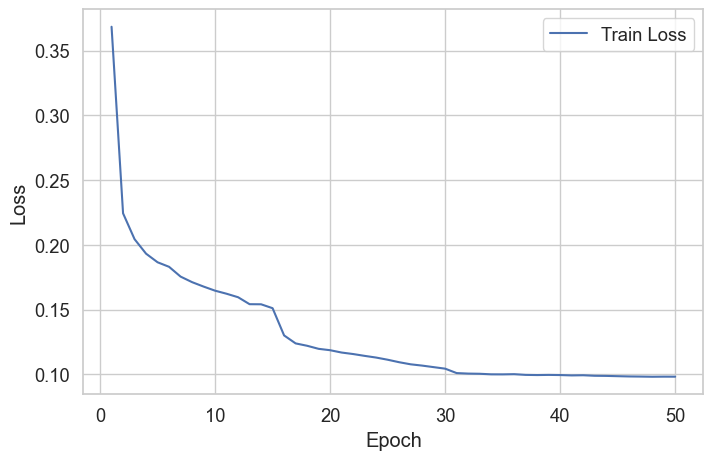

In [11]:
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=train_loss_history, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()



Dice & IoU Validation History

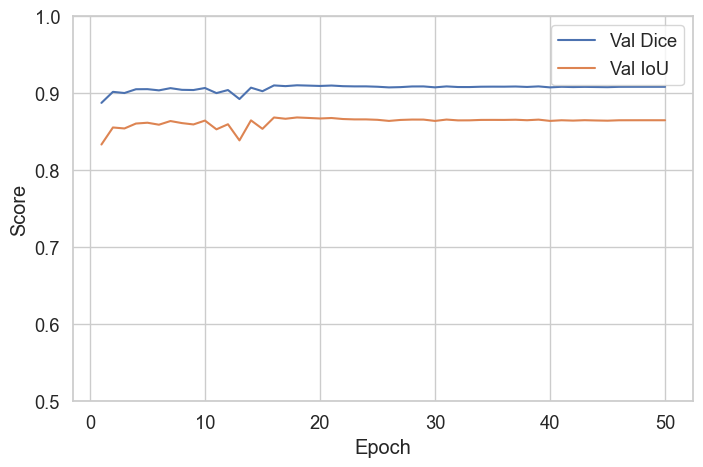

In [36]:
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=val_dice_history, label='Val Dice')
sns.lineplot(x=epochs, y=val_iou_history, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.ylim(0.5, 1)
plt.legend()
plt.show()


Aditional metrics history

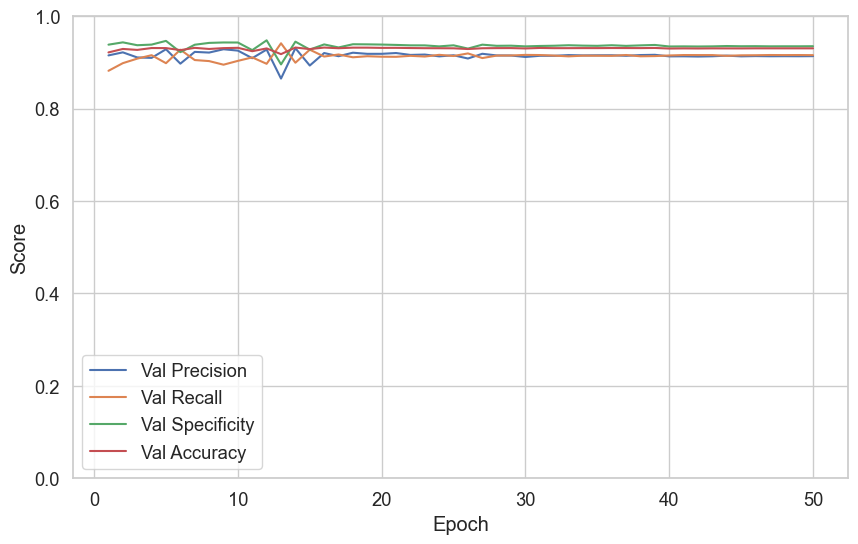

In [37]:
plt.figure(figsize=(10,6))
sns.lineplot(x=epochs, y=val_precision_history, label='Val Precision')
sns.lineplot(x=epochs, y=val_recall_history, label='Val Recall')
sns.lineplot(x=epochs, y=val_specificity_history, label='Val Specificity')
sns.lineplot(x=epochs, y=val_accuracy_history, label='Val Accuracy')
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()


Learning rate history

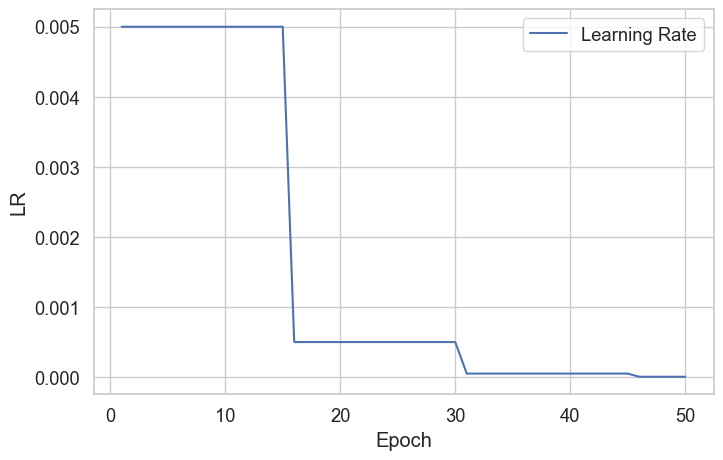

In [16]:
plt.figure(figsize=(8,5))
sns.lineplot(x=epochs, y=lr_history, label='Learning Rate')
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)
plt.legend()
plt.show()


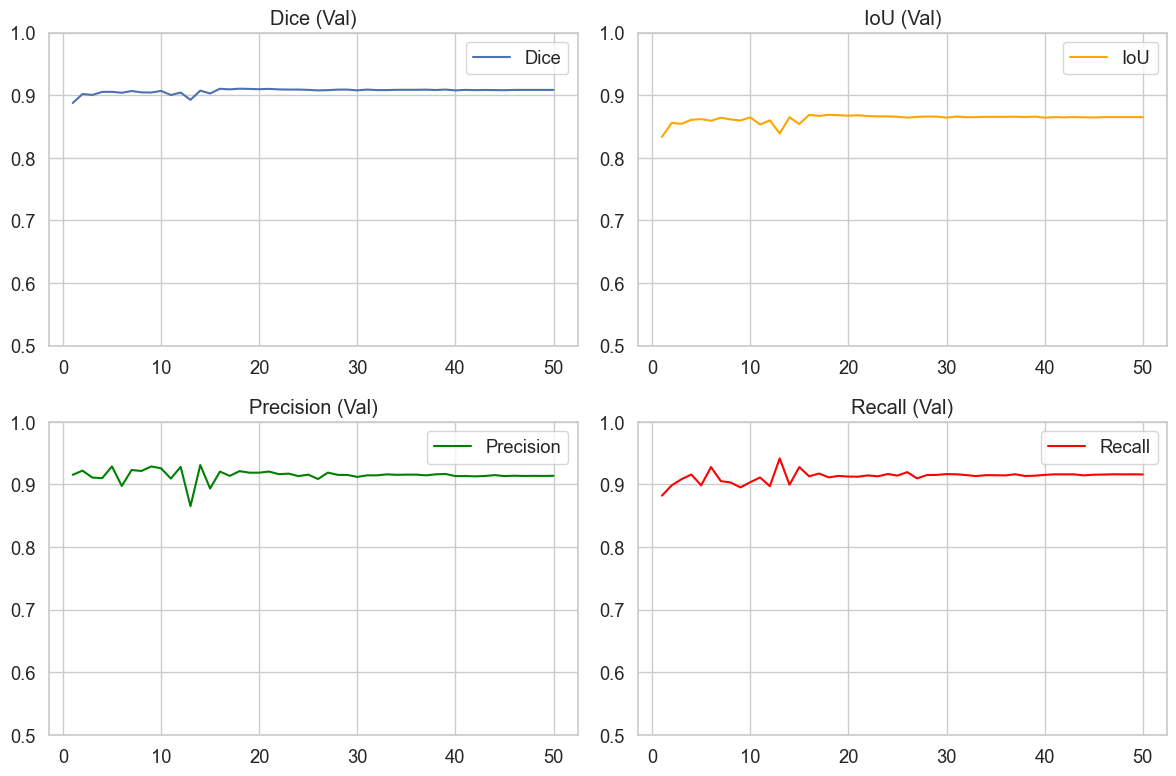

In [18]:
epoch_range = np.arange(1, len(val_dice_history)+1)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.lineplot(x=epoch_range, y=val_dice_history, label='Dice')
plt.title("Dice (Val)")
plt.grid(True)
plt.ylim(0.5, 1)
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=epoch_range, y=val_iou_history, label='IoU', color='orange')
plt.title("IoU (Val)")
plt.grid(True)
plt.ylim(0.5, 1)
plt.legend()

plt.subplot(2,2,3)
sns.lineplot(x=epoch_range, y=val_precision_history, label='Precision',color='green')
plt.title("Precision (Val)")
plt.grid(True)
plt.ylim(0.5, 1)
plt.legend()

plt.subplot(2,2,4)
sns.lineplot(x=epoch_range, y=val_recall_history, label='Recall', color='red')
plt.title("Recall (Val)")
plt.ylim(0.5, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### 5.3 Final Validation Metrics (20% Test Set)

In [132]:
mean_metrics, all_results = evaluate(model, data_loader_test, device)

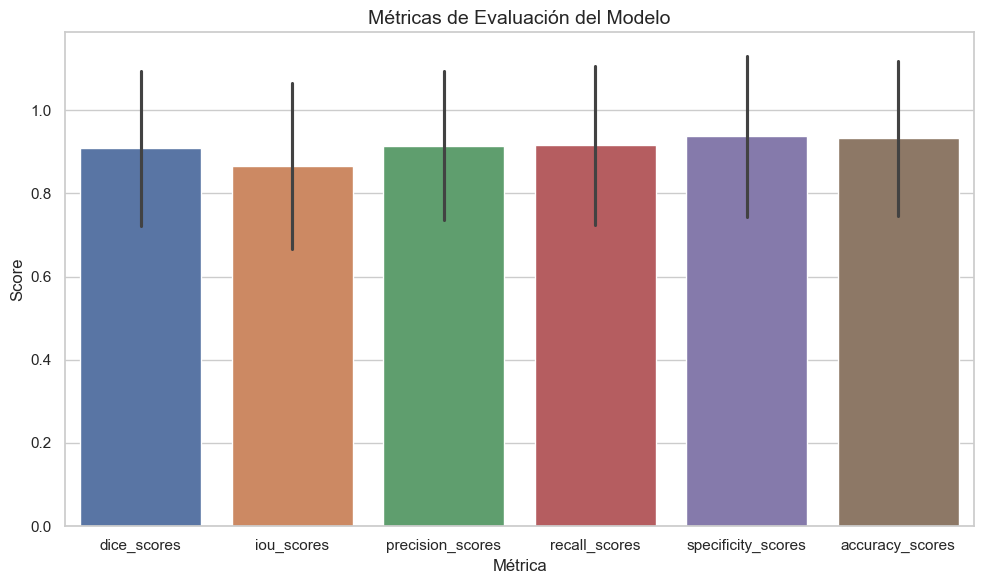

In [133]:
plt.figure(figsize=(10, 6))

sns.barplot(data=all_results, x="metric",y="value", hue="metric",errorbar="sd", legend=False )

plt.title("Métricas de Evaluación del Modelo", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Métrica", fontsize=12)
plt.tight_layout()
plt.show()

In [134]:
print("\n=== FINAL TEST METRICS (20%) ===")
mean_metrics.head(10)


=== FINAL TEST METRICS (20%) ===


,metric,value,std
0,mean_dice,0.908155,0.186466
1,mean_iou,0.865367,0.199938
2,mean_precision,0.914273,0.178999
3,mean_recall,0.915913,0.191324
4,mean_specificity,0.937071,0.193375
5,mean_accuracy,0.932063,0.186494


In [ ]:
all_results.to_csv('../results/test_metrics_maskrcnn_ham10000.csv', index=False)
print("Test metrics saved to test_metrics_maskrcnn_ham10000.csv")

In [ ]:
mean_metrics.to_csv('../results/test_mean_metrics_maskrcnn_ham10000.csv', index=False)
print("Test metrics saved to test_mean_metrics_maskrcnn_ham10000.csv")

Test metrics saved to test_metrics_maskrcnn_ham10000.csv


### 5.4 Visual Assessment of Segmentation Quality

In [ ]:
model.eval()

img, _ = test_ds[0]
with torch.no_grad():
    prediction = model([img.to(device)])

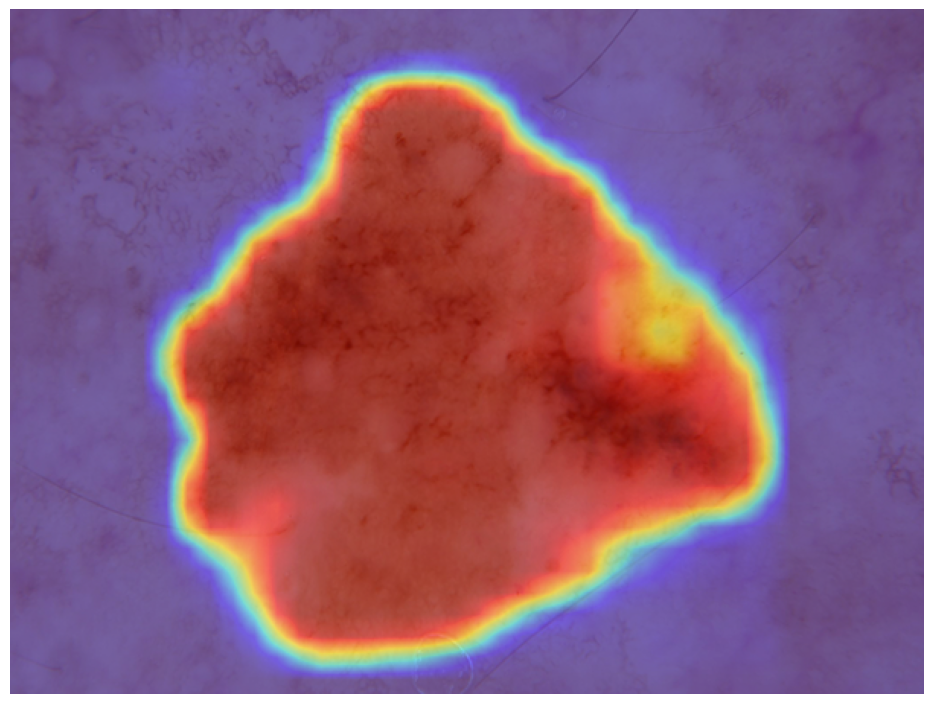

In [85]:
img_show = img.mul(255).permute(1, 2, 0).byte().numpy()
plt.figure(figsize=(10,10))
plt.imshow(img_show)

masks = prediction[0]['masks']
scores = prediction[0]['scores']
mask_threshold = 0.5

if len(masks) > 0 and scores[0] > mask_threshold:
    mask_show = masks[0, 0].mul(255).byte().cpu().numpy()
    plt.imshow(mask_show, alpha=0.5, cmap='jet')

plt.tight_layout()
plt.axis('off')
plt.show()

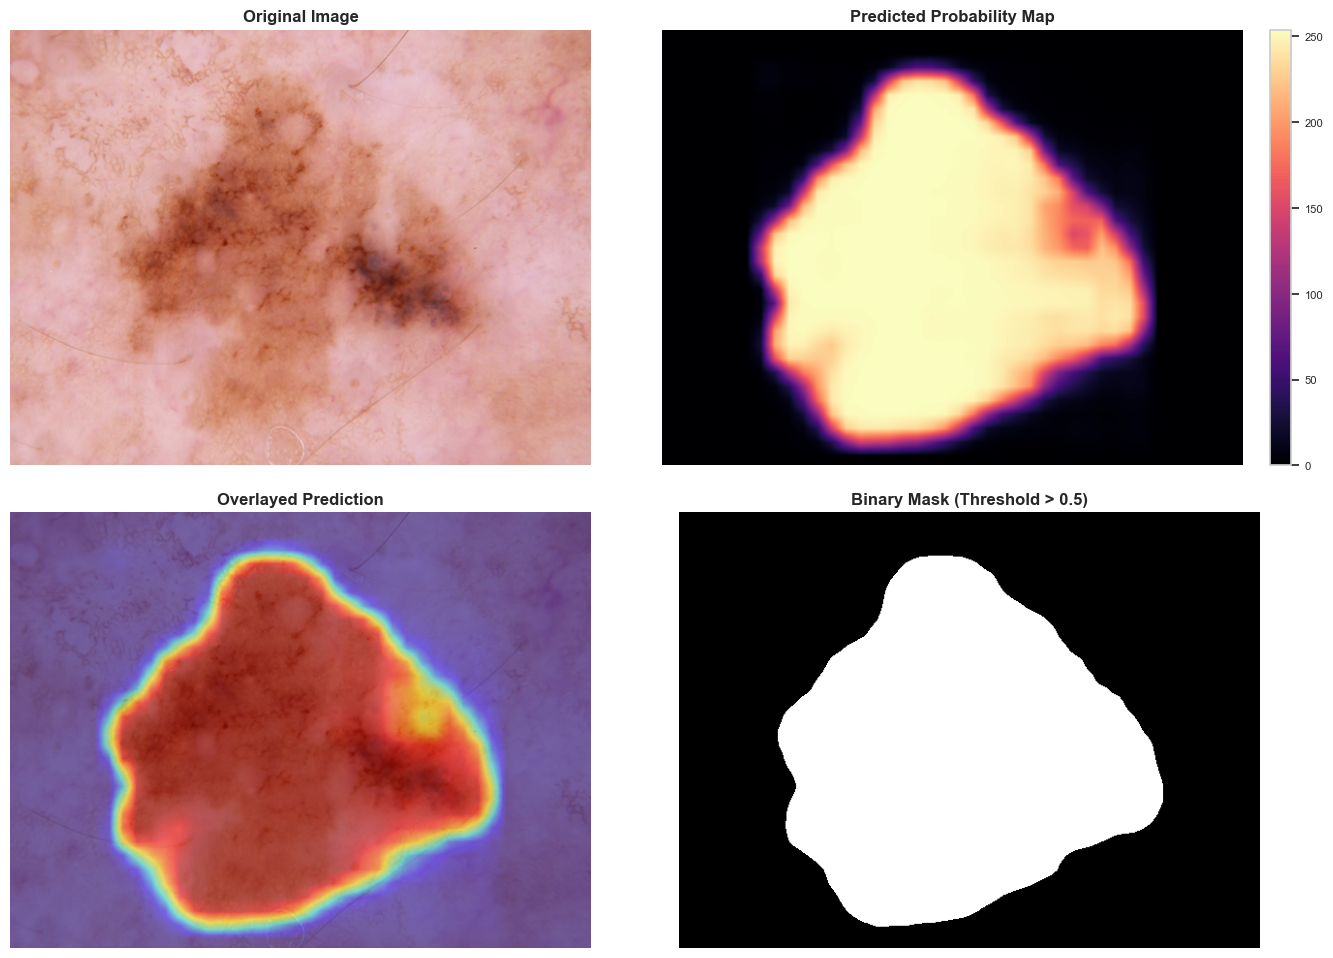

In [ ]:
img_show = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()
mask_show = masks[0, 0].mul(255).byte().cpu().numpy()

binary_mask = mask_show > 128

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# --- A. Original Image ---
ax1 = axes[0, 0]
ax1.imshow(img_show)
ax1.set_title('Original Image', fontsize=12, fontweight='bold')
ax1.axis('off')

# --- B. Predicted Mask (Con Colorbar) ---
ax2 = axes[0, 1]
im2 = ax2.imshow(mask_show, cmap='magma') 
ax2.set_title('Predicted Probability Map', fontsize=12, fontweight='bold')
ax2.axis('off')
cbar = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)

# --- C. Overlayed Image ---
ax3 = axes[1, 0]
ax3.imshow(img_show)
ax3.imshow(mask_show, alpha=0.5, cmap='jet') 
ax3.set_title('Overlayed Prediction', fontsize=12, fontweight='bold')
ax3.axis('off')

# --- D. Binary Mask ---
ax4 = axes[1, 1]
ax4.imshow(binary_mask, cmap='gray')
ax4.set_title('Binary Mask (Threshold > 0.5)', fontsize=12, fontweight='bold')
ax4.axis('off')


plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()